In [1]:
# Get the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, roc_curve, auc, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier, _fit_binary
from itertools import cycle, product
from sklearn.manifold import TSNE, MDS, Isomap
import seaborn as sns
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
import time
#from sklearn.externals.joblib import Parallel, delayed
from sklearn.ensemble import VotingClassifier
from joblib import Parallel, delayed

In [2]:
# Reading the data
failure = pd.read_csv('TargetData.csv')

In [3]:
# Inspecting the data
pd.options.display.max_rows = 1000
print(failure.shape)
print(failure.head(3).transpose()) # 3093 data points with 1 ID, 58 features and 5 targets
print(failure.describe().transpose()) # 3 features do not have any variance: 'gallop 1','gallop 5','Row Shift 7'

(3093, 64)
                                      0                  1                  2
ID                    076269B:09:N06:35  076269B:08:N02:23  076269B:09:P01:52
cell charge                           1                  0                  1
long activation 1                     0                  0                  1
gallop 1                              0                  0                  0
Fast Row Precharge 1                  0                  0                  1
Row Shift 1                           0                  0                  1
Column Short Type 1                   0                  0                  1
very late write 1                     0                  0                  1
Slow row 1                            0                  0                  1
Column Short Type 2                   0                  0                  1
Long pause 1                          0                  0                  1
Activate-to-read 1                    0              

ROW                   3093.0  0.327837  0.469501  0.0  0.0  0.0  1.0  1.0


In [4]:
# Set up the data and label
#X consists of 58 features. Each feature represents 1 test in the long test flow.
X = failure.drop(['ID', 'gallop 1', 'gallop 5', 'Row Shift 7', 'SB','COL', 'Margin', 'Block', 'ROW'], axis=1)
#Y can be one of ROW,COL,SB. ROW means the failure is on a row of memory array.
#COL means the failure is on a column of the cell array
#SB is single bit failure inside the memory
#Forming 8 class from 3 columns, coded as 0 to 7
#['Overkill','SB','COL','SB+COL','ROW','ROW+SB','ROW+COL','SB+ROW+COL']
  #y = failure.SB+2*failure.COL+4*failure.ROW

#Converting y to reflect multilabels
  #mlb = MultiLabelBinarizer()
  #y_converted = mlb.fit_transform(failure[['SB','COL','ROW']])

target = ['multilabels', 'SB', 'ROW', 'COL']
y = [None] * len(target)

y[0] = failure[['SB', 'ROW', 'COL']].values
n_classes = y[0].shape[1]

for (i, j) in zip(range(1, len(target)), ['SB', 'ROW', 'COL']):
    y[i] = failure[j].values

In [5]:
# Runnig the t-SNE model
i = ['SB', 'ROW', 'COL'] 

for i in i:
    failure[i] = failure[i].replace({0: 'Negative', 1: 'Positive'})

# Create a t-SNE model with learning rate 50
embedding = TSNE(n_components=2,
                 perplexity=30,
                 learning_rate=200.0,
                 verbose=10,
                 random_state=42)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = pd.DataFrame(embedding.fit_transform(X))

tsne_features_failure = tsne_features.join([failure['SB'], failure['ROW'], failure['COL']])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3093 samples in 0.561s...
[t-SNE] Computed neighbors for 3093 samples in 2.985s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3093
[t-SNE] Computed conditional probabilities for sample 2000 / 3093
[t-SNE] Computed conditional probabilities for sample 3000 / 3093
[t-SNE] Computed conditional probabilities for sample 3093 / 3093
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.880s
[t-SNE] Iteration 50: error = 62.4724350, gradient norm = 0.0729481 (50 iterations in 7.339s)
[t-SNE] Iteration 100: error = 51.2578964, gradient norm = 0.0308795 (50 iterations in 4.349s)
[t-SNE] Iteration 150: error = 47.4513092, gradient norm = 0.0306882 (50 iterations in 3.574s)
[t-SNE] Iteration 200: error = 45.6535110, gradient norm = 0.0292443 (50 iterations in 3.071s)
[t-SNE] Iteration 250: error = 44.5002403, gradient norm = 0.0122209 (50 iterations in 2.451s)
[t-SNE] KL divergence after 250 iterati

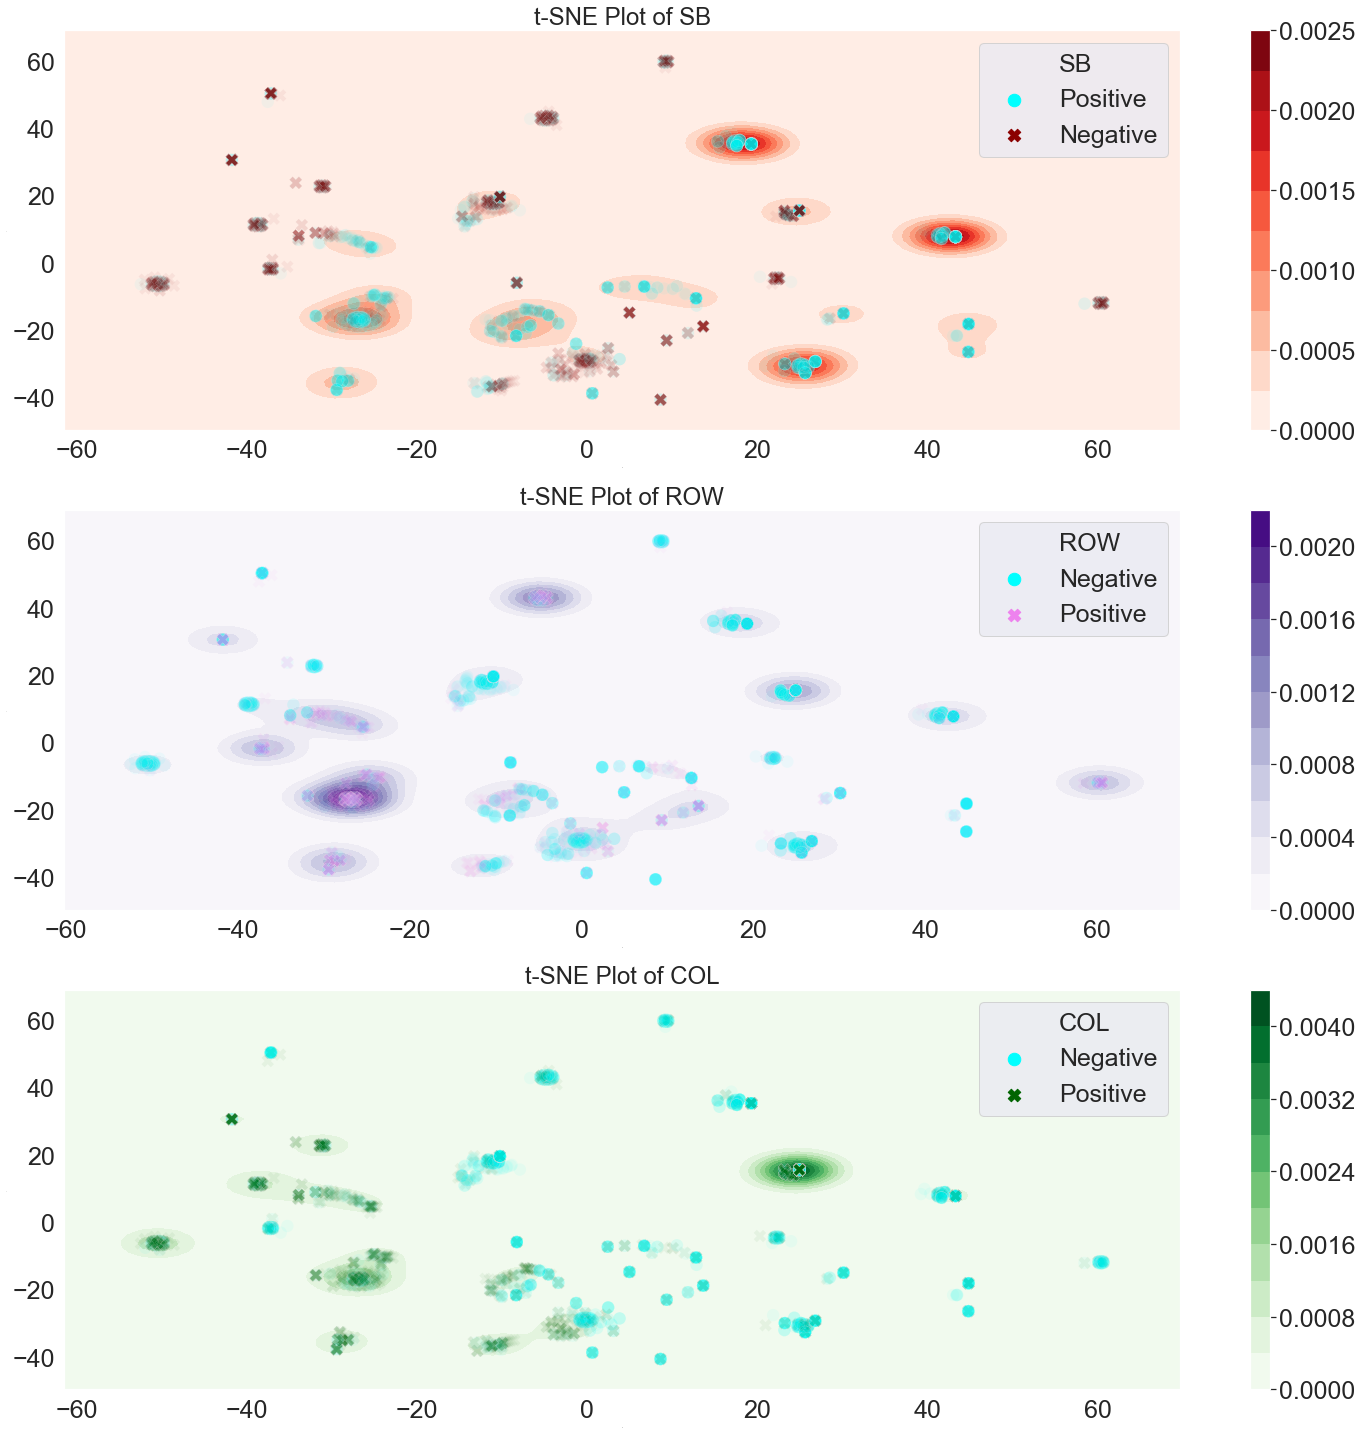

In [6]:
# Color the points according to types of failure
sns.set(rc={'figure.figsize': (25,25), 'legend.fontsize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
            'lines.markersize': 12.5, 'axes.labelsize': 0, 'axes.titlesize': 24})

fig, ax = plt.subplots(3,1)

j = ['SB', 'ROW', 'COL']
k = ['Reds', 'Purples', 'Greens']
l = ['darkred', 'violet', 'darkgreen']

for (i, j, k, l) in zip(range(n_classes), j, k, l):
    
    ax[i].set_title('t-SNE Plot of {}'.format(j))
    
    sns.kdeplot(data=tsne_features_failure[tsne_features_failure[j] == 'Positive'][0],
                data2=tsne_features_failure[tsne_features_failure[j] == 'Positive'][1],
                cmap=k,
                shade=True,
                bw=3,
                cbar=True, 
                ax=ax[i])
    
    sns.scatterplot(x=tsne_features_failure[0],
                    y=tsne_features_failure[1],
                    hue=tsne_features_failure[j],
                    style=tsne_features_failure[j],
                    palette=['aqua', l],
                    alpha=0.05,
                    ax=ax[i])

In [7]:
# Train/test split
y_train = [None] * len(target)
y_test = [None] * len(target)

for i in range(len(target)):
    X_train, X_test, y_train[i], y_test[i] = train_test_split(X, y[i],
                                                              test_size=1/3,
                                                              random_state=42,
                                                              stratify=y[0])

100%|██████████| 1000/1000 [36:57<00:00,  2.63s/it, best loss: 0.38409047312774336] 
multilabels----------
                                                                    
activation          logistic  logistic      relu      relu      relu
alpha               0.992007   1.13701   6.19402   5.99743   5.95018
hidden_layer_sizes        29        12        34        37        45
learning_rate       constant  constant  constant  constant  constant
learning_rate_init  0.404835   0.79396  0.554658  0.217494  0.370662
power_t              0.98897  0.835499  0.696323  0.796261  0.875802
solver                 lbfgs     lbfgs     lbfgs     lbfgs     lbfgs
best_score           0.61591  0.615909  0.615424  0.615423   0.61494
__________                                                                 
Hidden Layers     (5, 35)   (4, 39)   (43, 3)   (4, 11)   (4, 47)
Mean Test Score  0.615907  0.614937  0.614452  0.614452  0.614452

100%|██████████| 1000/1000 [17:59<00:00,  1.18s/it, best loss: 

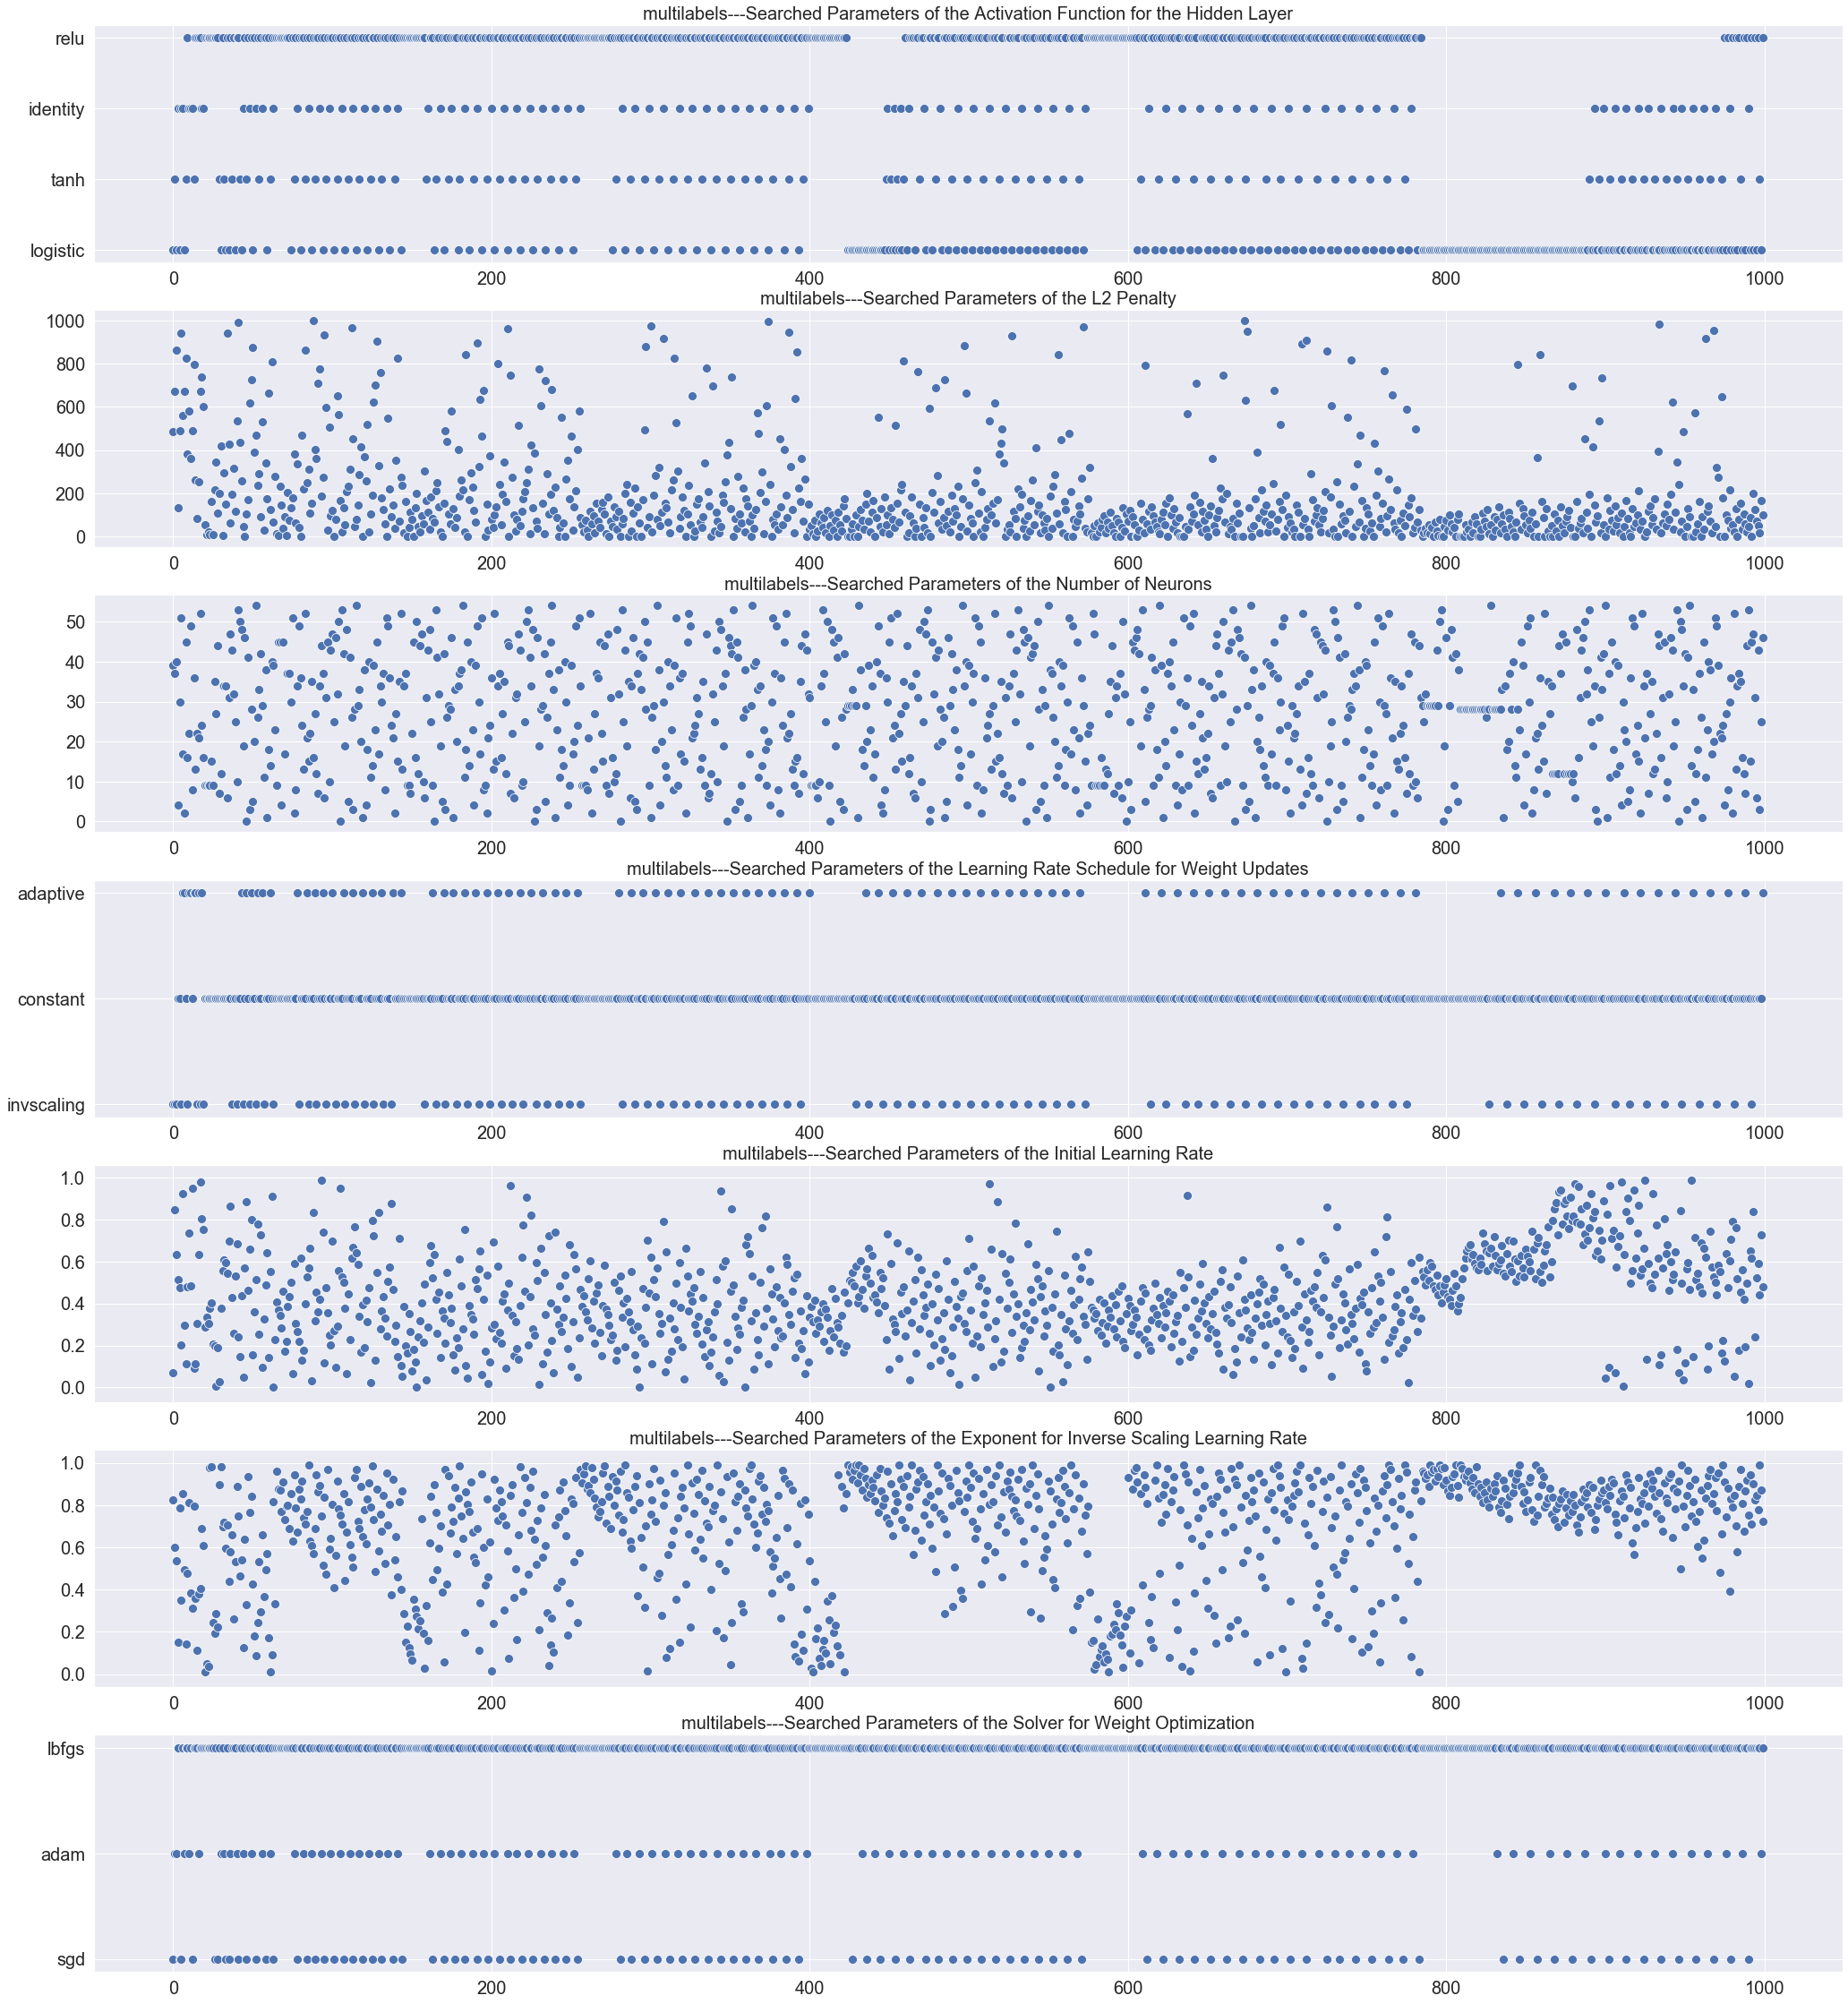

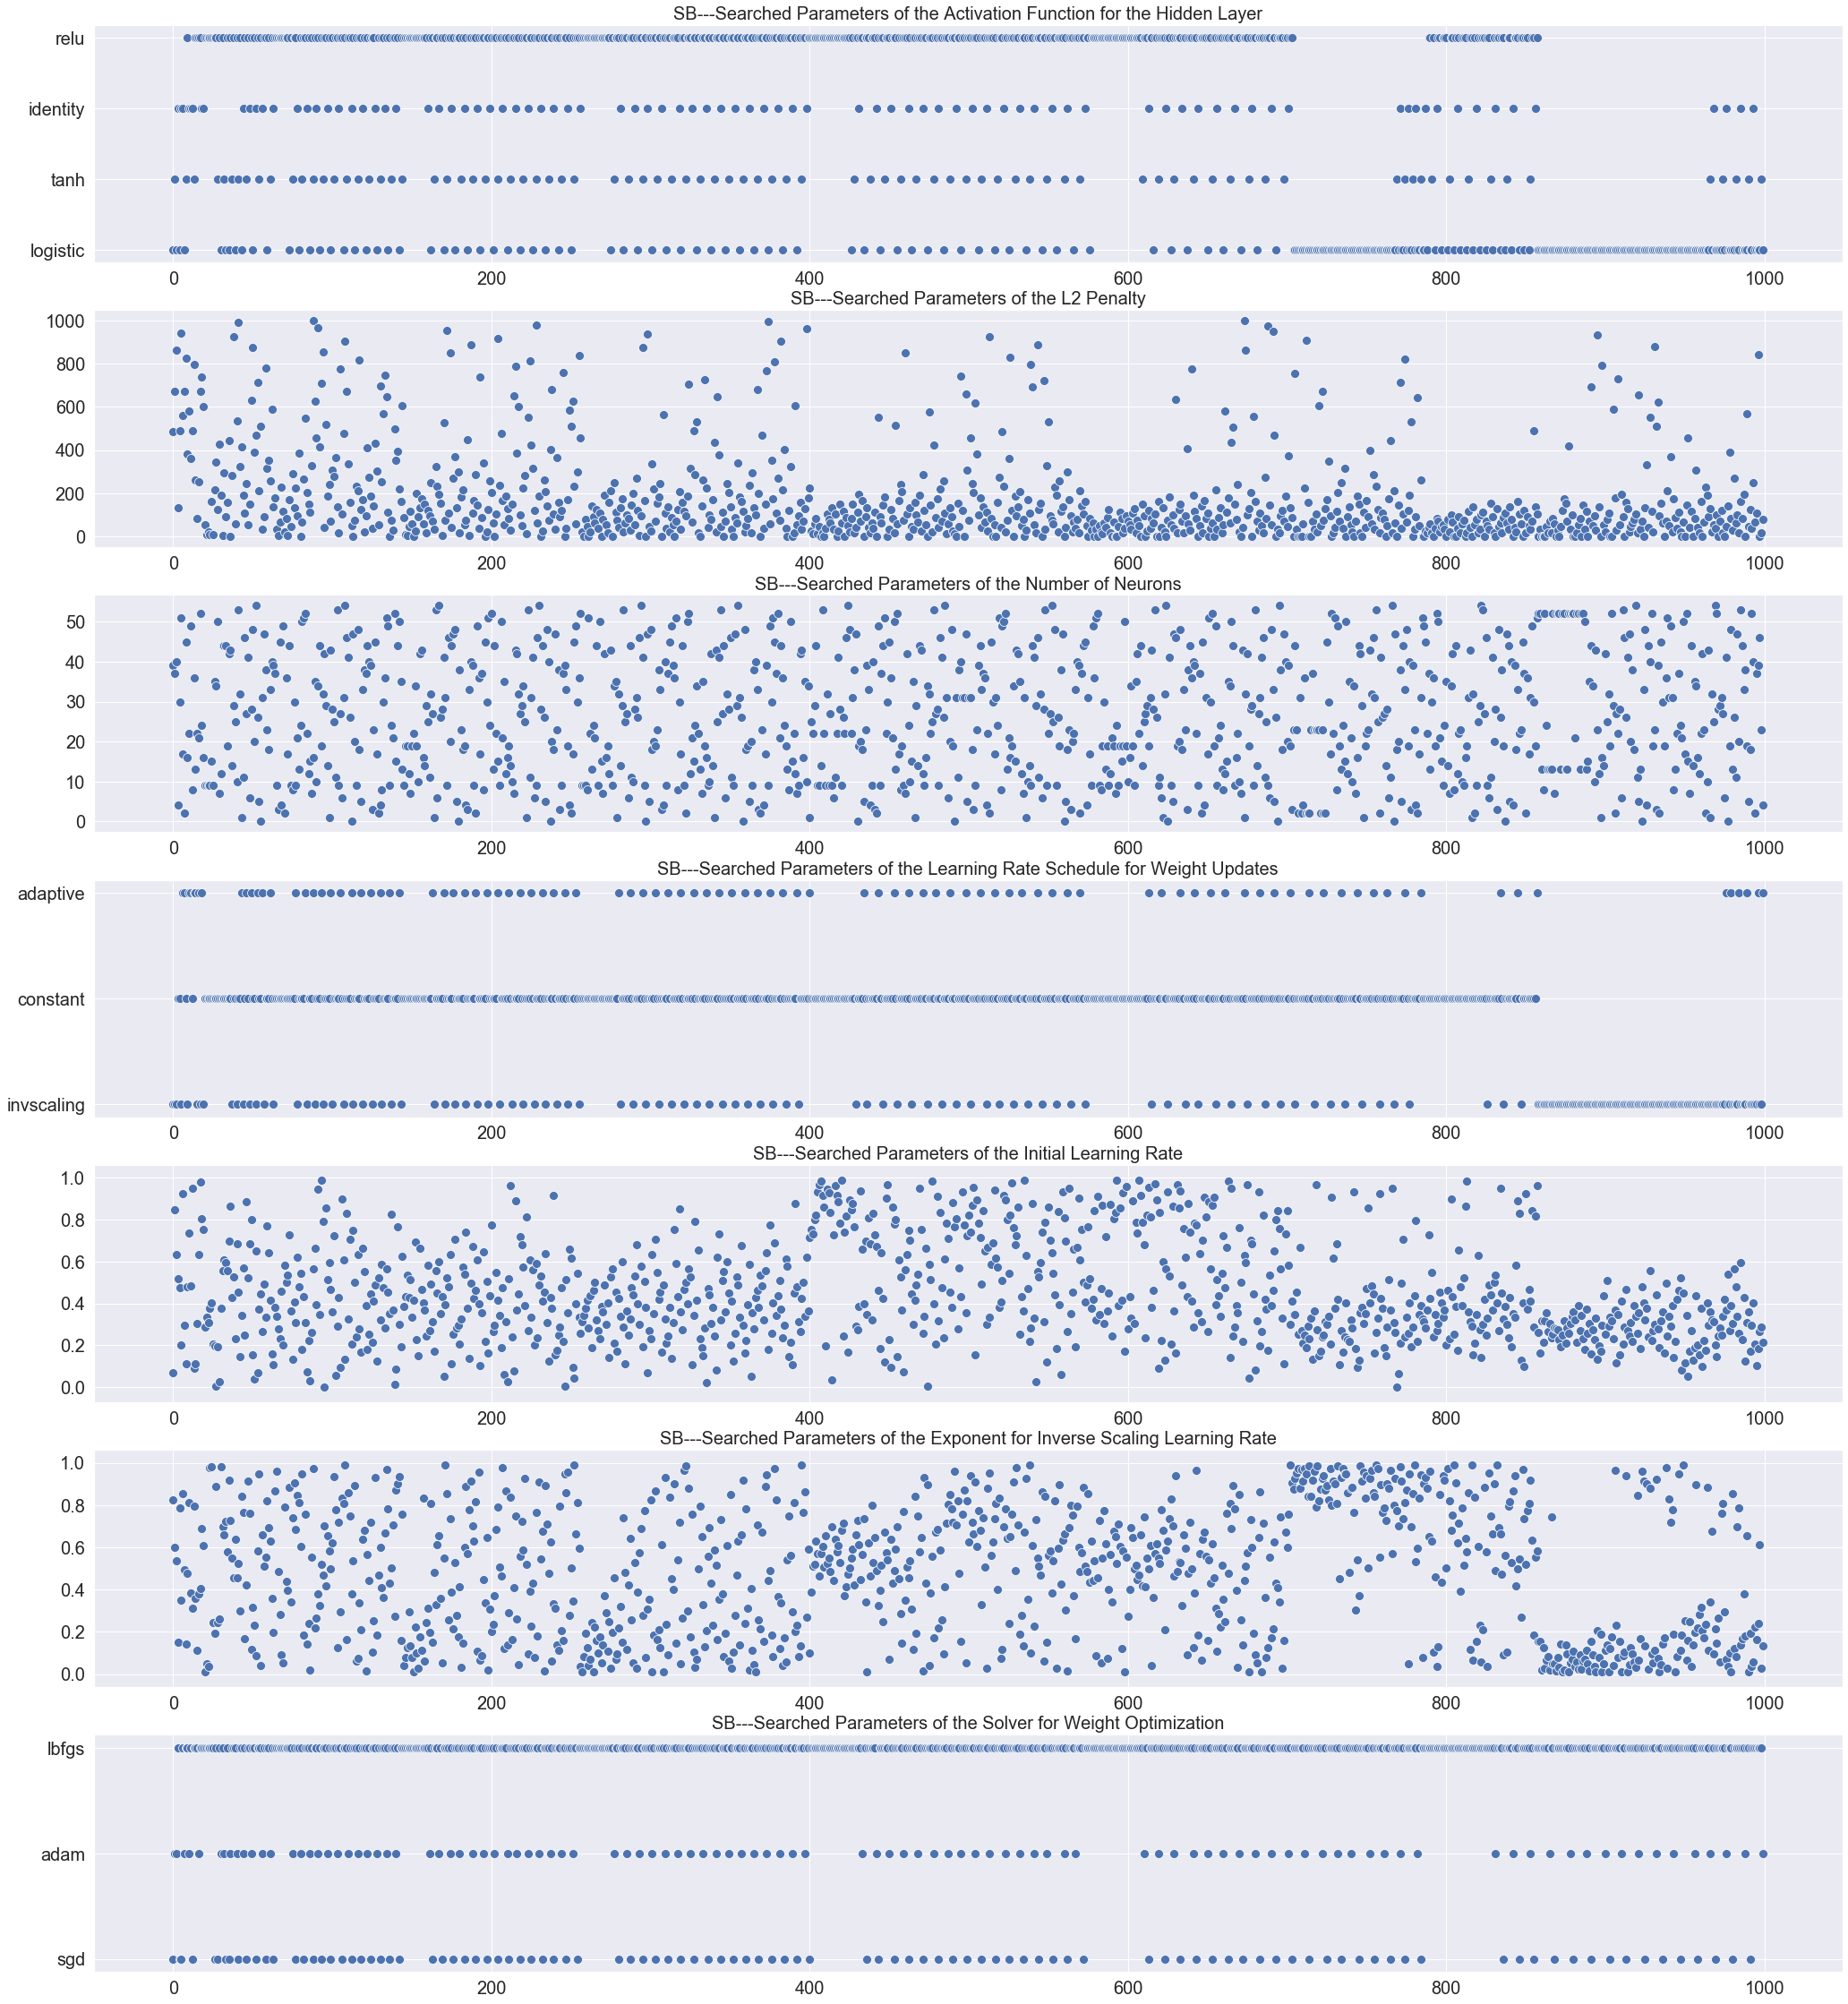

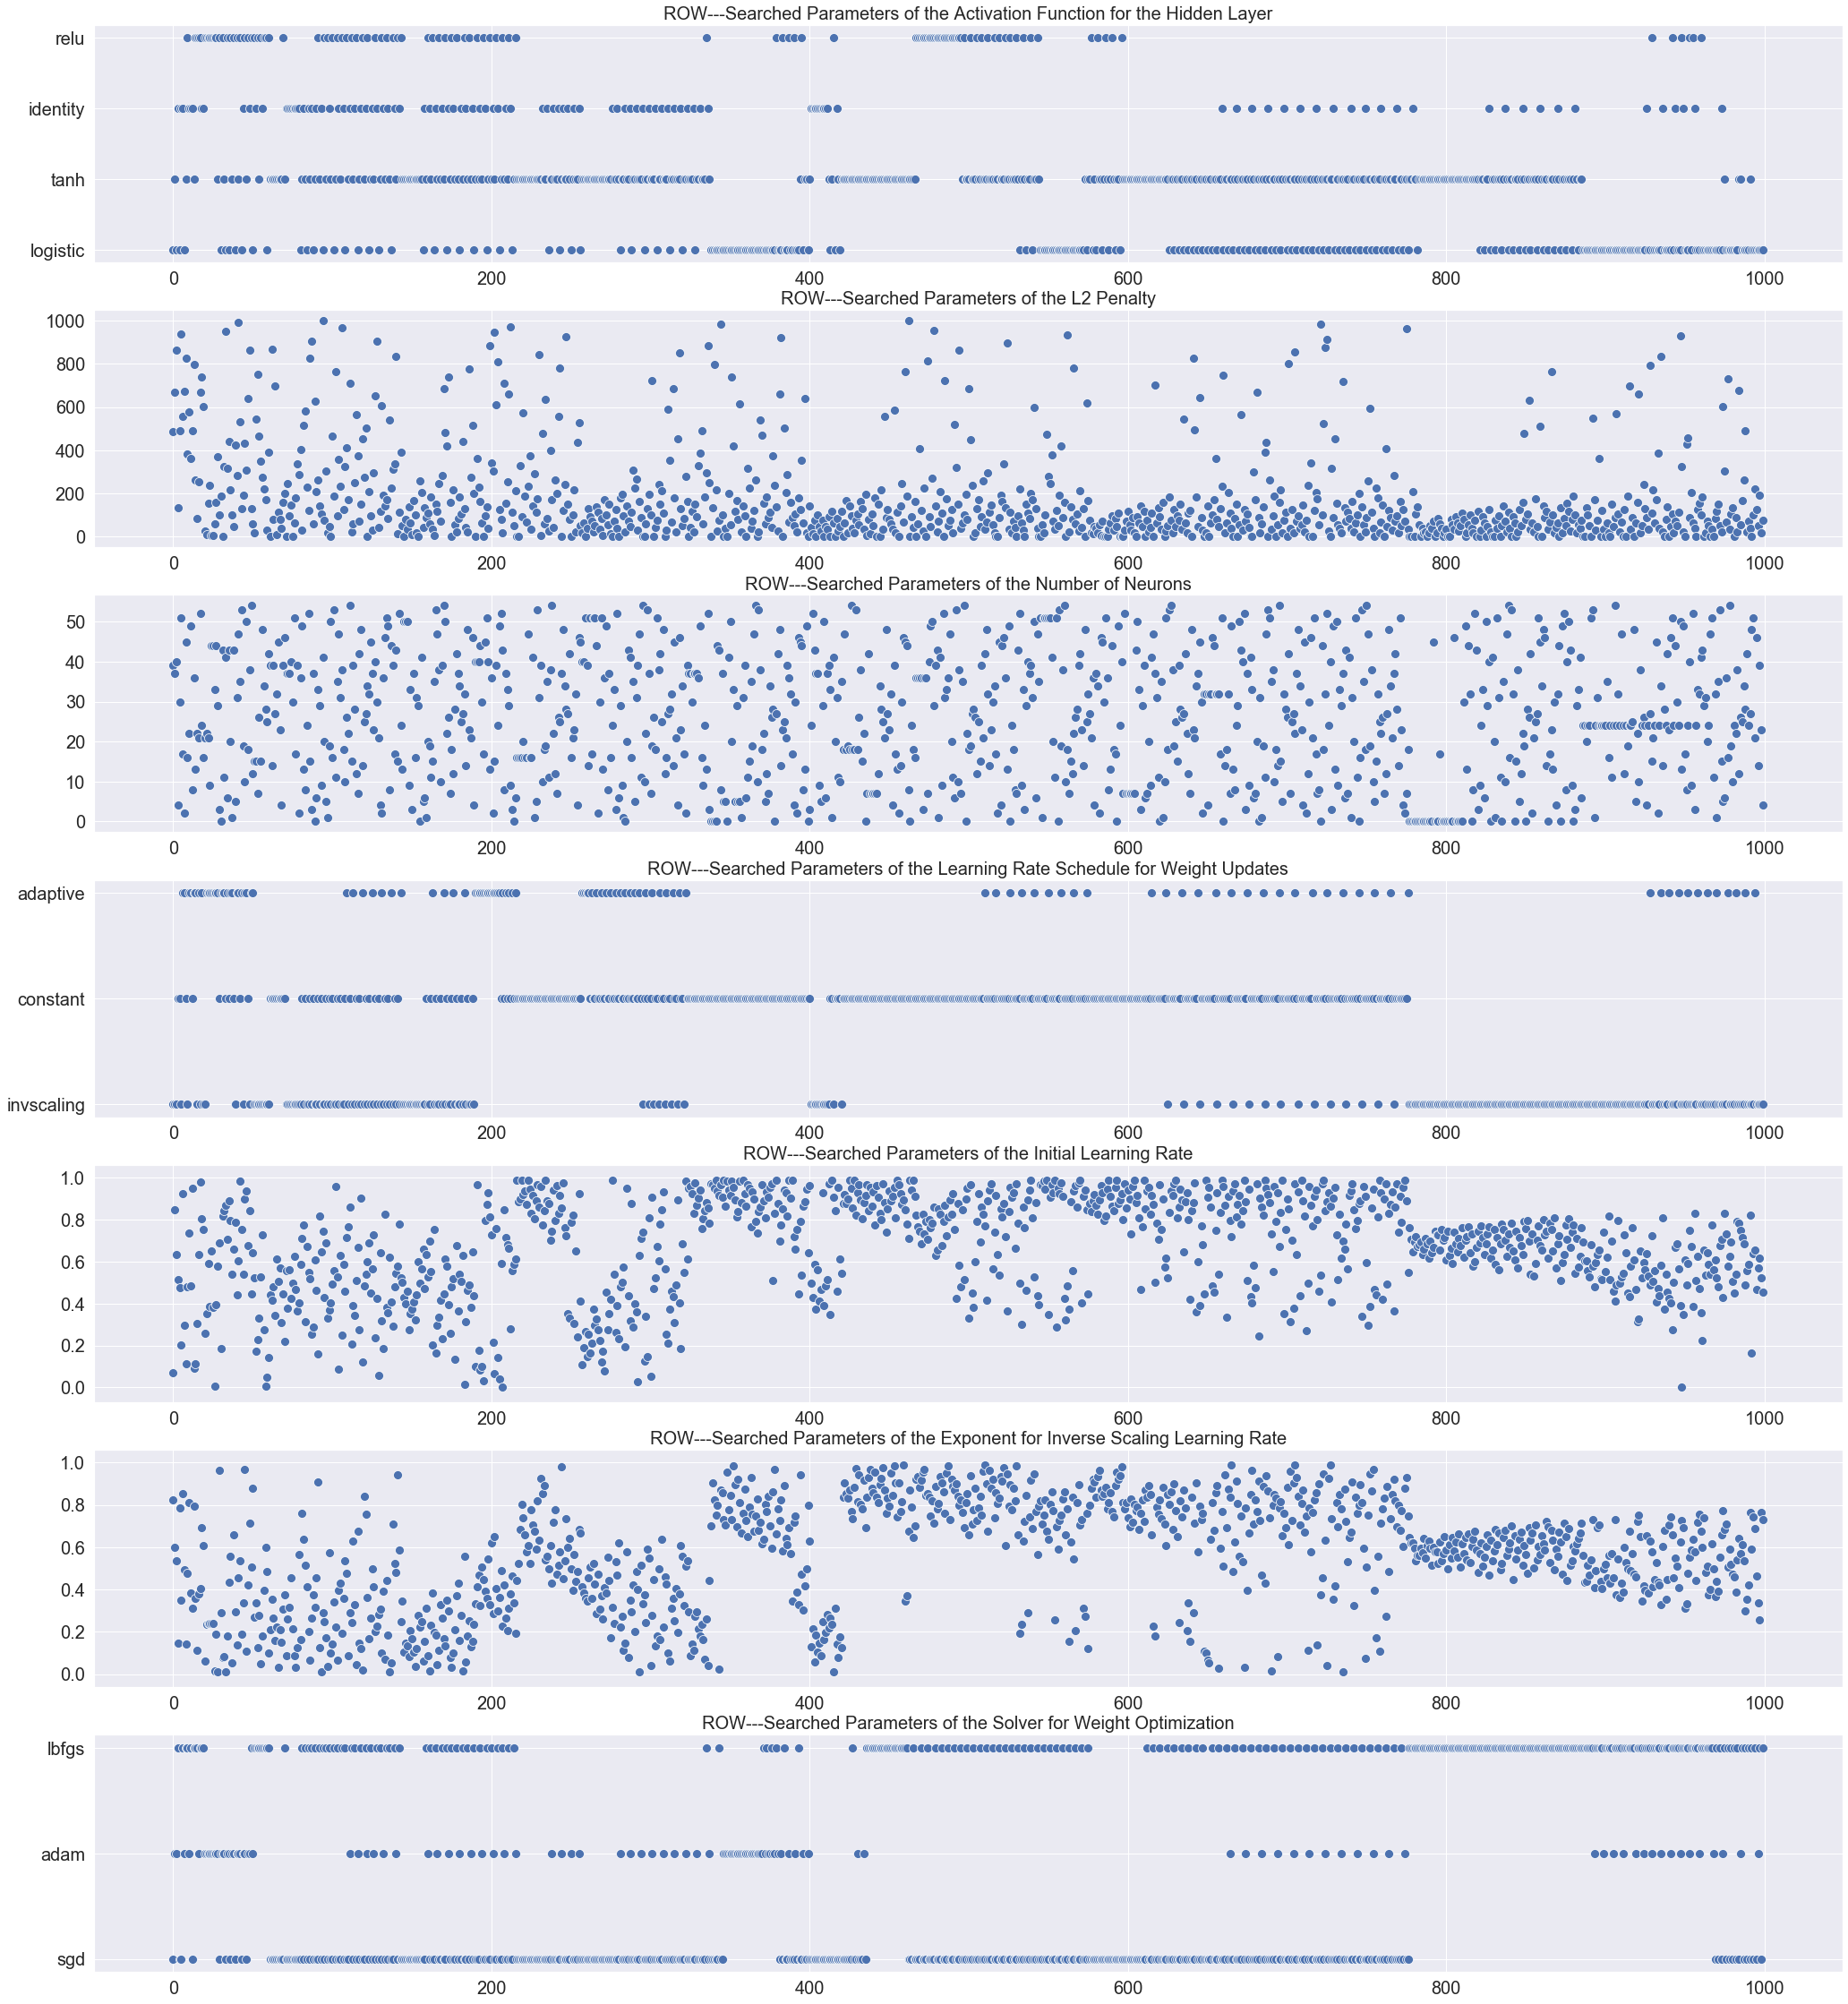

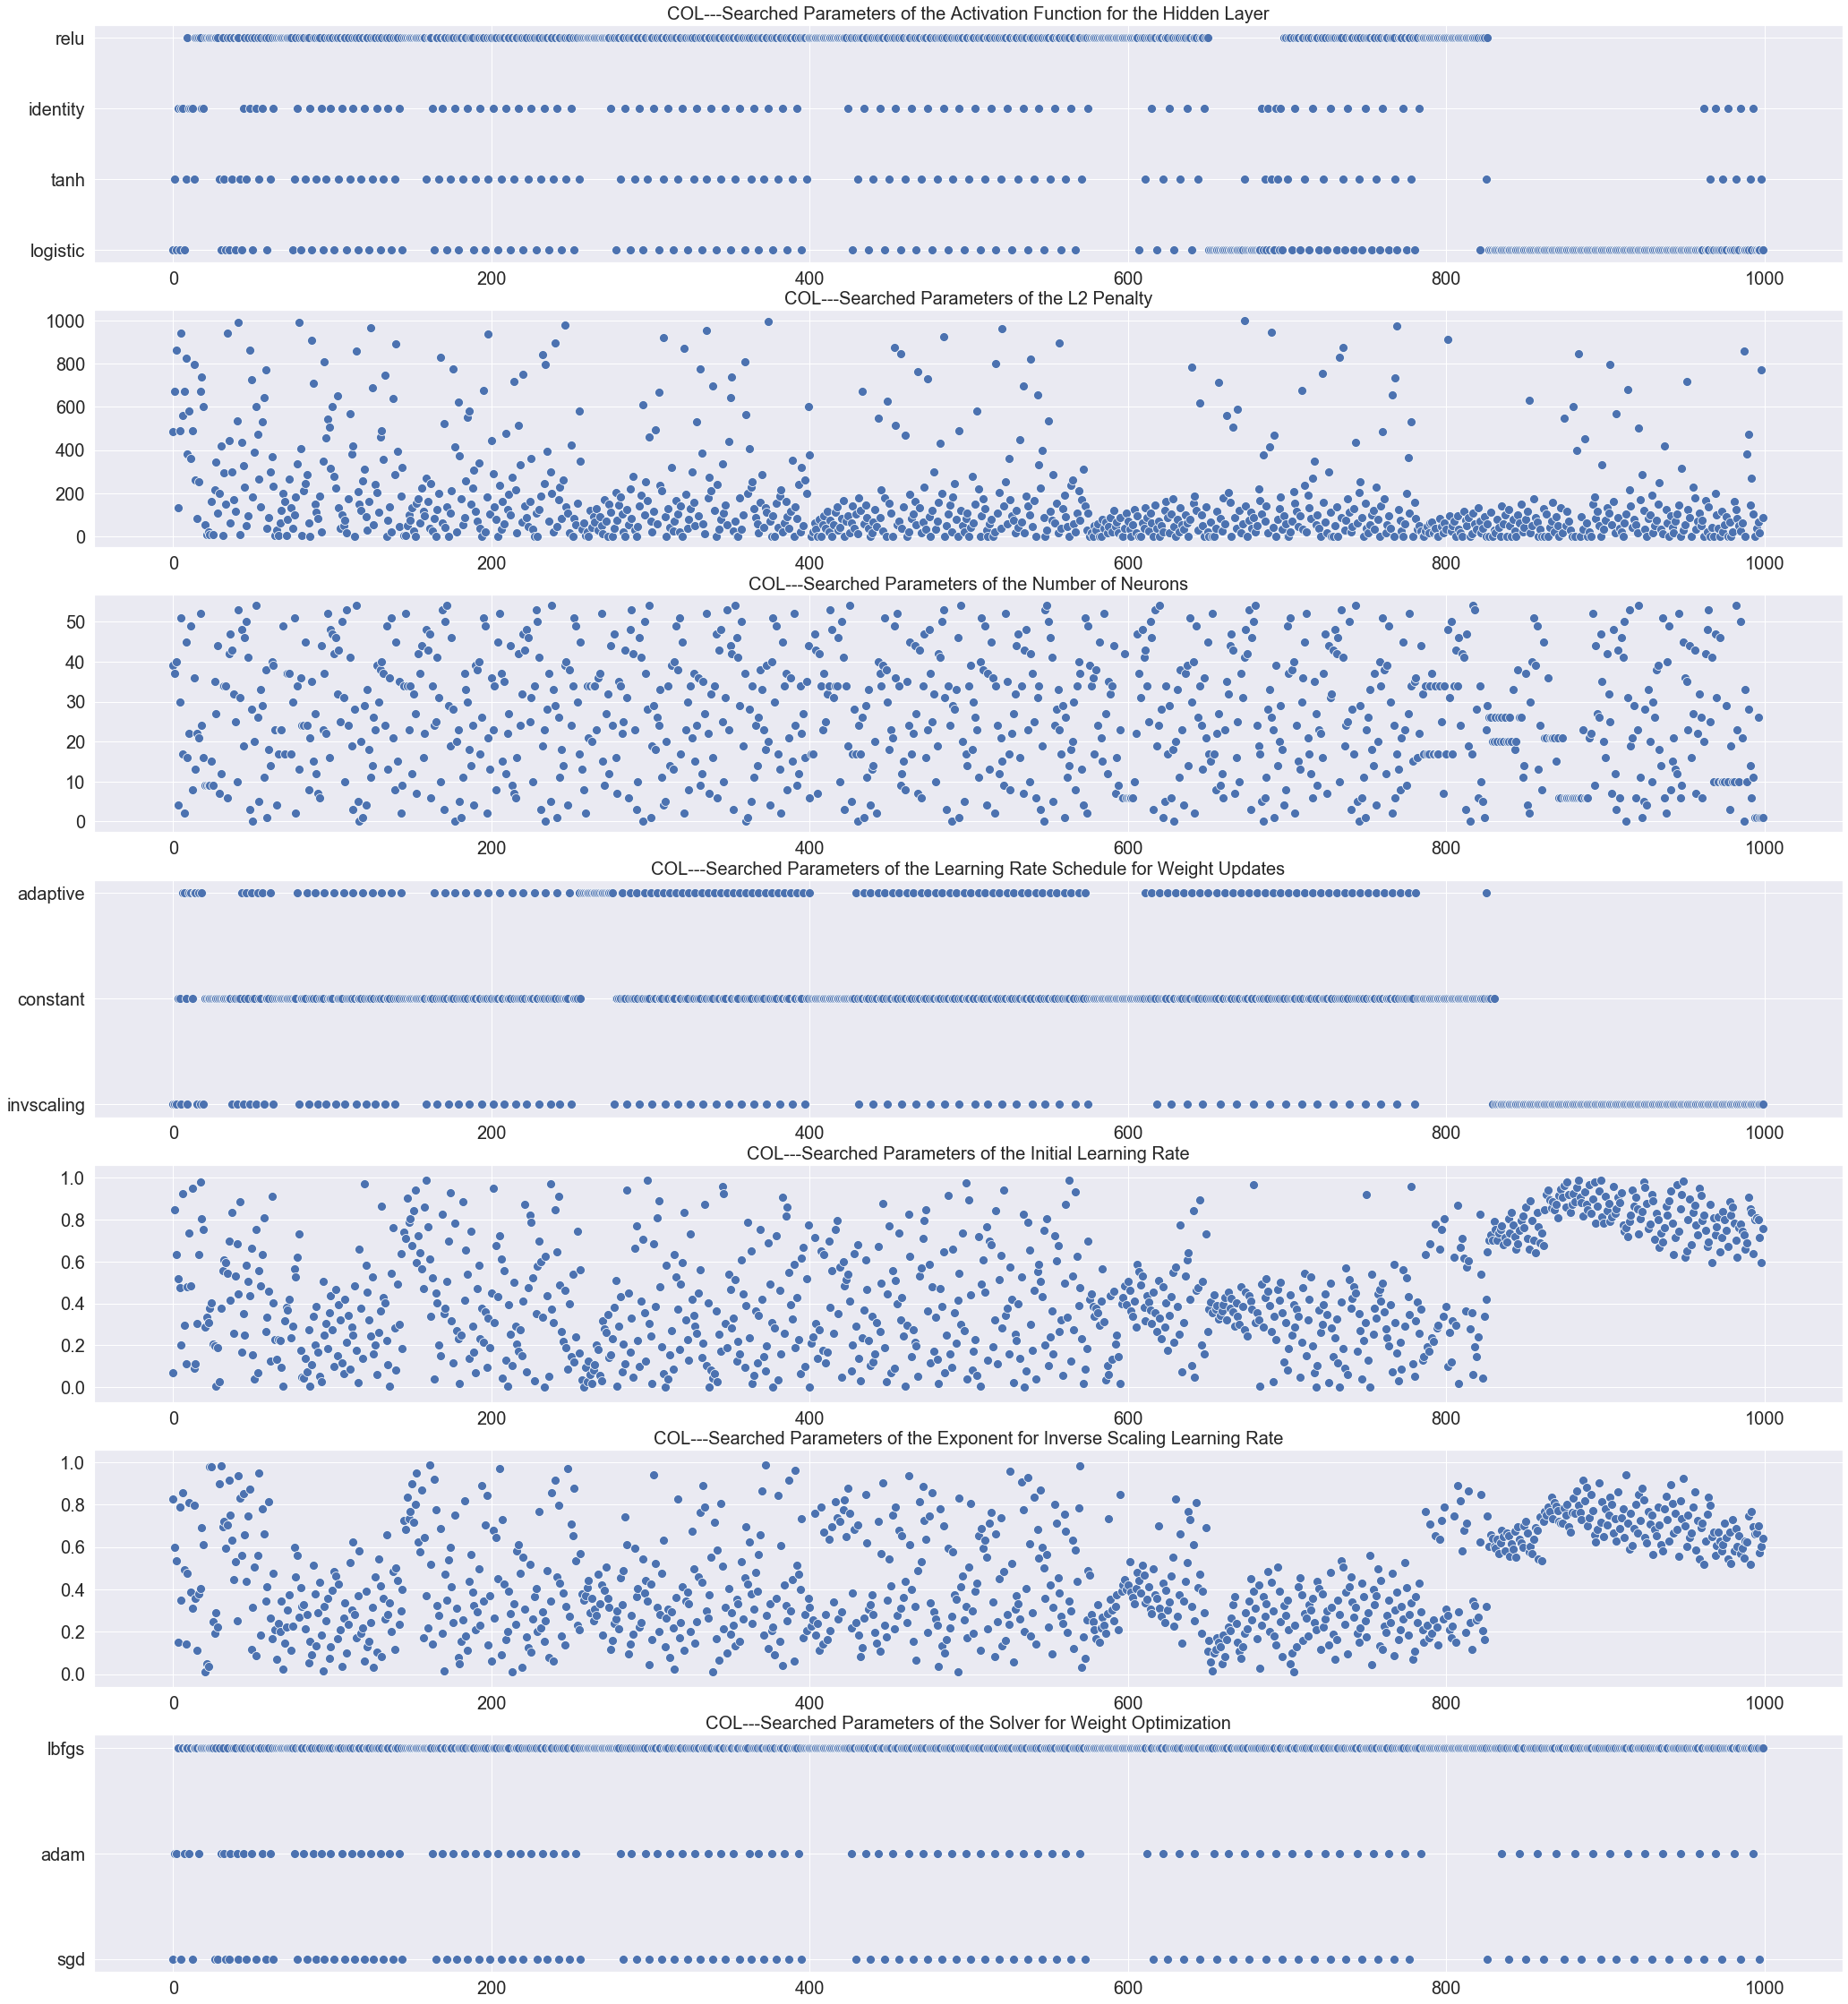

In [8]:
# Set up space dictionary with specified hyperparameters
space = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', range(1,56)),
         'activation': hp.choice('activation', ['logistic','tanh','relu', 'identity']),
         'solver': hp.choice('solver', ['lbfgs','sgd','adam']),
         'alpha': hp.uniform('alpha', 0.0001, 1000),
         'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
         'learning_rate_init': hp.uniform('learning_rate_init', 0.001, 0.99),
         'power_t': hp.uniform('power_t', 0.01, 0.99)}

wave = -1

target_clf = [None] * len(target)
target_clf_fitted = [None] * len(target)
target_y_pred_proba = [None] * len(target)
target_y_pred = [None] * len(target)

for i in range(len(target)):
    target_clf[i] = [None] * 12
    target_clf_fitted[i] = [None] * 12
    target_y_pred_proba[i] = [None] * 12
    target_y_pred[i] = [None] * 12

for (i, j) in zip(range(len(target)), ['multilabels', 'SB', 'ROW', 'COL']):
    
    wave = wave + 1
    
    # Set up objective function
    def objective(params):
        params = {'hidden_layer_sizes': params['hidden_layer_sizes'],
                  'activation': params['activation'],
                  'solver': params['solver'],
                  'alpha': params['alpha'],
                  'learning_rate': params['learning_rate'],
                  'learning_rate_init': params['learning_rate_init'],
                  'power_t': params['power_t']}
        
        hyperopt_clf = MLPClassifier(max_iter=4000,
                                     random_state=42,
                                     warm_start=True,
                                     early_stopping=True,
                                     **params)

        best_score = cross_val_score(estimator=hyperopt_clf,
                                     X=X_train,
                                     y=y_train[i],
                                     cv=3,
                                     n_jobs=4,
                                     pre_dispatch=10).mean()
    
        loss = 1 - best_score
        return {'best_score': best_score, 'loss': loss, 'status': STATUS_OK,'eval_time': time.time()}

    # Run the algorithm
    trials = Trials()
    best = fmin(fn=objective,
           space=space,
           max_evals=1000,
           rstate=np.random.RandomState(42),
           algo=tpe.suggest,
           trials=trials)
    
    print('{}----------'.format(j))
    
    best_score = [None] * len(trials.trials)
    best_score[0] = trials.results[0].get('best_score')

    searched_params_df = pd.DataFrame(trials.trials[0].get('misc').get('vals').values())
    searched_params_df = searched_params_df.transpose()

    for i in list(range(1, len(trials.trials))):
        new_df = pd.DataFrame(trials.trials[i].get('misc').get('vals').values())
        searched_params_df = searched_params_df.append(new_df.transpose())
        best_score[i] = trials.results[i].get('best_score')

    searched_params_df = searched_params_df.rename(columns={0: 'activation', 1: 'alpha', 2: 'hidden_layer_sizes', 
                                                            3: 'learning_rate', 4: 'learning_rate_init', 
                                                            5: 'power_t', 6: 'solver'})
    
    blankIndex = [''] * len(searched_params_df)
    searched_params_df.index = blankIndex
    
    i = ['activation', 'learning_rate', 'solver']
    j = ['logistic', 'constant', 'lbfgs']
    k = ['tanh', 'invscaling', 'sgd']
    l = ['relu', 'adaptive', 'adam']
    m = ['identity']

    for (i, j, k, l) in zip(i, j, k, l):
         searched_params_df[i] = searched_params_df[i].replace({0: j, 1: k, 2: l, 3: m})

    searched_params_df['best_score'] = best_score

    searched_params_df_sorted = searched_params_df.sort_values(by='best_score', 
                                                               axis=0, 
                                                               ascending=False)
    
    searched_params_df_sorted = searched_params_df_sorted[searched_params_df_sorted.hidden_layer_sizes != 0]

    print(searched_params_df_sorted.head(5).transpose())
    print('__________')
    
    # Learn to predict each class against the other
        
    for i in range(5):
        target_clf[wave][i] = MLPClassifier(max_iter=4000,
                                            random_state=42,
                                            warm_start=True,
                                            early_stopping=True,
                                            activation=searched_params_df_sorted.values[i][0],
                                            alpha=searched_params_df_sorted.values[i][1],
                                            hidden_layer_sizes=int(searched_params_df_sorted.values[i][2]),
                                            learning_rate=searched_params_df_sorted.values[i][3],
                                            learning_rate_init=searched_params_df_sorted.values[i][4],
                                            power_t=searched_params_df_sorted.values[i][5],
                                            solver=searched_params_df_sorted.values[i][6])
    
    if wave == 0:
        for i in range(5):
            target_clf_fitted[wave][i] = target_clf[wave][i].fit(X_train, y_train[wave])
            target_y_pred_proba[wave][i] = target_clf[wave][i].predict_proba(X_test)
            target_y_pred[wave][i] = target_clf[wave][i].predict(X_test)
    else:
        # Create and fit the voting classifier
        target_clf[wave][5] = VotingClassifier(estimators=[('first', target_clf[wave][0]), 
                                                           ('second', target_clf[wave][1]), 
                                                           ('third', target_clf[wave][2]), 
                                                           ('forth', target_clf[wave][3]),
                                                           ('fifth', target_clf[wave][4])],
                                                voting='soft',
                                                n_jobs=4)
    
        for i in range(6):
            target_clf_fitted[wave][i] = target_clf[wave][i].fit(X_train, y_train[wave])
            target_y_pred_proba[wave][i] = target_clf[wave][i].predict_proba(X_test)
            target_y_pred[wave][i] = target_clf[wave][i].predict(X_test)

    # Create the parameter grid
    param_grid = {'hidden_layer_sizes': list(product(range(1,56), range(1,56)))}
    
    # Create a random search object
    ran_clf = RandomizedSearchCV(estimator = MLPClassifier(max_iter=4000,
                                                           random_state=42,
                                                           warm_start=True,
                                                           early_stopping=True,
                                                           activation=searched_params_df_sorted.values[0][0],
                                                           alpha=searched_params_df_sorted.values[0][1],
                                                           learning_rate=searched_params_df_sorted.values[0][3],
                                                           learning_rate_init=searched_params_df_sorted.values[0][4],
                                                           power_t=searched_params_df_sorted.values[0][5],
                                                           solver=searched_params_df_sorted.values[0][6]),
                                 param_distributions=param_grid,
                                 n_iter=465,
                                 n_jobs=4,
                                 pre_dispatch=100,
                                 cv=3,
                                 random_state=42)

    ran_clf_fitted = ran_clf.fit(X_train, y_train[wave])

    #Configuration of Layer 1 & 2
    mean_test_score = list(ran_clf_fitted.cv_results_.get('mean_test_score'))
    hidden_layers = list(ran_clf_fitted.cv_results_.get('param_hidden_layer_sizes'))

    best_hidden_layers_df = pd.DataFrame({'Hidden Layers': hidden_layers, 'Mean Test Score': mean_test_score})

    blankIndex = [''] * len(best_hidden_layers_df)
    best_hidden_layers_df.index = blankIndex

    # Print out the best configuration of hidden layers
    best_hidden_layers_df_sorted = best_hidden_layers_df.sort_values(by='Mean Test Score', 
                                                                     axis=0, 
                                                                     ascending=False)

    print(best_hidden_layers_df_sorted.head(5).transpose())
    print()

    for i in range(6, 11):
        target_clf[wave][i] = MLPClassifier(max_iter=4000,
                                            random_state=42,
                                            warm_start=True,
                                            early_stopping=True,
                                            activation=searched_params_df_sorted.values[0][0],
                                            alpha=searched_params_df_sorted.values[0][1],
                                            hidden_layer_sizes=best_hidden_layers_df_sorted['Hidden Layers'].values[i-6],
                                            learning_rate=searched_params_df_sorted.values[0][3],
                                            learning_rate_init=searched_params_df_sorted.values[0][4],
                                            power_t=searched_params_df_sorted.values[0][5],
                                            solver=searched_params_df_sorted.values[0][6])
    
    if wave == 0:
        for i in range(6, 11):
            target_clf_fitted[wave][i] = target_clf[wave][i].fit(X_train, y_train[wave])
            target_y_pred_proba[wave][i] = target_clf[wave][i].predict_proba(X_test)
            target_y_pred[wave][i] = target_clf[wave][i].predict(X_test)
    else:
        # Create and fit the voting classifier
        target_clf[wave][11] = VotingClassifier(estimators=[('first', target_clf[wave][6]), 
                                                            ('second', target_clf[wave][7]), 
                                                            ('third', target_clf[wave][8]), 
                                                            ('forth', target_clf[wave][9]),
                                                            ('fifth', target_clf[wave][10])],
                                                voting='soft',
                                                n_jobs=4)
    
        for i in range(6, 12):
            target_clf_fitted[wave][i] = target_clf[wave][i].fit(X_train, y_train[wave])
            target_y_pred_proba[wave][i] = target_clf[wave][i].predict_proba(X_test)
            target_y_pred[wave][i] = target_clf[wave][i].predict(X_test)
    
    #sns.set(rc={'figure.figsize': (20,20), 'legend.fontsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
            #'lines.markersize': 10, 'axes.labelsize': 20, 'axes.titlesize': 20})

    #first_hidden_layer = [None] * len(hidden_layers)
    #second_hidden_layer = [None] * len(hidden_layers)

    #for i in range(len(hidden_layers)):
        #first_hidden_layer[i] = hidden_layers[i][0]
        #second_hidden_layer[i] = hidden_layers[i][1]

    #ax = sns.scatterplot(x=first_hidden_layer,
                         #y=second_hidden_layer)
    #ax.set_title('Scatterplot of the Combination of the Number of Neurons in the First & Second Hidden Layers')
 
    # Color the points according to types of failure
    sns.set(rc={'figure.figsize': (35,40), 'legend.fontsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                'lines.markersize': 10, 'axes.labelsize': 0, 'axes.titlesize': 20})

    fig, ax = plt.subplots(7,1)

    j = ['Activation Function for the Hidden Layer', 'L2 Penalty', 'Number of Neurons', 
         'Learning Rate Schedule for Weight Updates', 'Initial Learning Rate', 'Exponent for Inverse Scaling Learning Rate',
         'Solver for Weight Optimization']
    k = ['activation', 'alpha', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'power_t', 'solver']
    
    for (i, j, k) in zip(range(7), j, k):
    
        ax[i].set_title('{}---Searched Parameters of the {}'.format(target[wave], j))
        sns.scatterplot(x=list(range(0, len(trials.trials))), 
                        y=searched_params_df[k].values, 
                        ax=ax[i])

In [43]:
# Print classification report
wave = -1

for (i, j) in zip(range(len(target)), ['multilabels', 'SB', 'ROW', 'COL']):
    wave = wave + 1
    
    print(j)
    
    if wave == 0:
        i = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]
        j = ['1stBest_1Layer', '2ndBest_1Layer', '3rdBest_1Layer', '4thBest_1Layer', '5thBest_1Layer', 
             '1stBest_2Layers', '2ndBest_2Layers', '3rdBest_2Layers', '4thBest_2Layers', '5thBest_2Layers']

        for (i, j) in zip(i, j):
            print('{}----------'.format(j))
            print()
            print(multilabel_confusion_matrix(y_true=y_test[wave], 
                                              y_pred=target_y_pred[wave][i]))
            print(classification_report(y_true=y_test[wave], 
                                        y_pred=target_y_pred[wave][i],
                                        target_names=['SB', 'ROW', 'COL'],
                                        digits=2))
    else:
        i = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        j = ['1stBest_1Layer', '2ndBest_1Layer', '3rdBest_1Layer', '4thBest_1Layer', '5thBest_1Layer', 'CombineBest_1Layer',
             '1stBest_2Layers', '2ndBest_2Layers', '3rdBest_2Layers', '4thBest_2Layers', '5thBest_2Layers', 'CombineBest_2Layers']

        for (i, j) in zip(i, j):
            print('{}----------'.format(j))
            print()
            print(confusion_matrix(y_true=y_test[wave], 
                                   y_pred=target_y_pred[wave][i]))
            print(classification_report(y_true=y_test[wave], 
                                        y_pred=target_y_pred[wave][i],
                                        target_names=['NonFault', 'Fault'],
                                        digits=2))

multilabels
1stBest_1Layer----------

[[[461  67]
  [ 92 411]]

 [[640  54]
  [123 214]]

 [[526  57]
  [110 338]]]
              precision    recall  f1-score   support

          SB       0.86      0.82      0.84       503
         ROW       0.80      0.64      0.71       337
         COL       0.86      0.75      0.80       448

   micro avg       0.84      0.75      0.79      1288
   macro avg       0.84      0.74      0.78      1288
weighted avg       0.84      0.75      0.79      1288
 samples avg       0.68      0.63      0.64      1288

2ndBest_1Layer----------

[[[461  67]
  [ 92 411]]

 [[641  53]
  [123 214]]

 [[526  57]
  [111 337]]]
              precision    recall  f1-score   support

          SB       0.86      0.82      0.84       503
         ROW       0.80      0.64      0.71       337
         COL       0.86      0.75      0.80       448

   micro avg       0.84      0.75      0.79      1288
   macro avg       0.84      0.73      0.78      1288
weighted avg       


3rdBest_2Layers----------

[[462  66]
 [ 93 410]]
              precision    recall  f1-score   support

    NonFault       0.83      0.88      0.85       528
       Fault       0.86      0.82      0.84       503

    accuracy                           0.85      1031
   macro avg       0.85      0.85      0.85      1031
weighted avg       0.85      0.85      0.85      1031

4thBest_2Layers----------

[[461  67]
 [ 93 410]]
              precision    recall  f1-score   support

    NonFault       0.83      0.87      0.85       528
       Fault       0.86      0.82      0.84       503

    accuracy                           0.84      1031
   macro avg       0.85      0.84      0.84      1031
weighted avg       0.85      0.84      0.84      1031

5thBest_2Layers----------

[[461  67]
 [ 93 410]]
              precision    recall  f1-score   support

    NonFault       0.83      0.87      0.85       528
       Fault       0.86      0.82      0.84       503

    accuracy                   


1stBest_2Layers----------

[[525  58]
 [108 340]]
              precision    recall  f1-score   support

    NonFault       0.83      0.90      0.86       583
       Fault       0.85      0.76      0.80       448

    accuracy                           0.84      1031
   macro avg       0.84      0.83      0.83      1031
weighted avg       0.84      0.84      0.84      1031

2ndBest_2Layers----------

[[525  58]
 [108 340]]
              precision    recall  f1-score   support

    NonFault       0.83      0.90      0.86       583
       Fault       0.85      0.76      0.80       448

    accuracy                           0.84      1031
   macro avg       0.84      0.83      0.83      1031
weighted avg       0.84      0.84      0.84      1031

3rdBest_2Layers----------

[[525  58]
 [109 339]]
              precision    recall  f1-score   support

    NonFault       0.83      0.90      0.86       583
       Fault       0.85      0.76      0.80       448

    accuracy                   

In [59]:
# Computing feature importance
print('Best MLP estimator: {}'.format(target_clf[0][0]))
print()
print('Best results')
print(multilabel_confusion_matrix(y_true=y_test[0], 
                                  y_pred=target_y_pred[0][0]))
print(classification_report(y_true=y_test[0], 
                            y_pred=target_y_pred[0][0],
                            target_names=['SB', 'ROW', 'COL'],
                            digits=2))

perm = PermutationImportance(estimator=target_clf[0][0],
                             n_iter=100,
                             random_state=42).fit(X_test, y_test[0])

# Create a dataframe of the variables and feature importances
feature_importances_df = pd.DataFrame({'Variable': X.columns, 'Feature_Importances': perm.feature_importances_})

# Print out the top 3 positive variables
feature_importances_df_sorted = feature_importances_df.sort_values(by='Feature_Importances', 
                                                                   axis=0, 
                                                                   ascending=False)
print()
print(feature_importances_df_sorted)

Best MLP estimator: MLPClassifier(activation='logistic', alpha=0.9920073082747223,
              batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=True,
              epsilon=1e-08, hidden_layer_sizes=29, learning_rate='constant',
              learning_rate_init=0.40483518981206684, max_iter=4000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.9889699087957667, random_state=42, shuffle=True,
              solver='lbfgs', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=True)

Best results
[[[461  67]
  [ 92 411]]

 [[640  54]
  [123 214]]

 [[526  57]
  [110 338]]]


C:\Users\Jacky\Anaconda3\envs\psupr\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\Jacky\Anaconda3\envs\psupr\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          SB       0.86      0.82      0.84       503
         ROW       0.80      0.64      0.71       337
         COL       0.86      0.75      0.80       448

   micro avg       0.84      0.75      0.79      1288
   macro avg       0.84      0.74      0.78      1288
weighted avg       0.84      0.75      0.79      1288
 samples avg       0.68      0.63      0.64      1288


                Variable  Feature_Importances
13           Amplifier 1             0.087401
18   Column Short Type 4             0.074471
0            cell charge             0.066644
8           Long pause 1             0.066324
15          Long pause 2             0.065732
4    Column Short Type 1             0.058109
2   Fast Row Precharge 1             0.056246
25           Row Shift 3             0.054384
3            Row Shift 1             0.054054
7    Column Short Type 2             0.051940
16     long activation 2             0.050592
12   Column 

In [45]:
### IGNORE
# Defining a custom OneVsRest classifier
class CustomOneVsRestClassifier(OneVsRestClassifier):

    # Changed the estimator to estimators which can take a list now
    def __init__(self, estimators, n_jobs=1):
        self.estimators = estimators
        self.n_jobs = n_jobs

    def fit(self, X, y):

        self.label_binarizer_ = LabelBinarizer(sparse_output=True)
        Y = self.label_binarizer_.fit_transform(y)
        Y = Y.tocsc()
        self.classes_ = self.label_binarizer_.classes_
        columns = (col.toarray().ravel() for col in Y.T)

        # This is where we change the training method
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)(
            estimator, X, column, classes=[
                "not %s" % self.label_binarizer_.classes_[i],
                self.label_binarizer_.classes_[i]])
            for i, (column, estimator) in enumerate(zip(columns, self.estimators)))
        return self

In [54]:
### IGNORE
estimators = []

estimators.append(target_clf[1][0])
estimators.append(target_clf[2][9])
estimators.append(target_clf[3][0])
clf = CustomOneVsRestClassifier(estimators)

clf.fit(X_train, y_train[0])

print(multilabel_confusion_matrix(y_true=y_test[0], 
                                  y_pred=clf.predict(X_test)))
print(classification_report(y_true=y_test[0], 
                            y_pred=clf.predict(X_test),
                            target_names=['SB', 'ROW', 'COL'],
                            digits=2))

[[[462  66]
  [ 93 410]]

 [[641  53]
  [126 211]]

 [[525  58]
  [108 340]]]


C:\Users\Jacky\Anaconda3\envs\psupr\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\Jacky\Anaconda3\envs\psupr\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

          SB       0.86      0.82      0.84       503
         ROW       0.80      0.63      0.70       337
         COL       0.85      0.76      0.80       448

   micro avg       0.84      0.75      0.79      1288
   macro avg       0.84      0.73      0.78      1288
weighted avg       0.84      0.75      0.79      1288
 samples avg       0.68      0.63      0.63      1288

